<h1>Importing Libraries</h1>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import zipfile
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,ConfusionMatrixDisplay
sns.set_style("whitegrid")
np.random.seed(69)

<h1>Getting the Data</h1>

In [3]:
import requests

def download_file_from_google_drive(url, destination_path):
    response = requests.get(url)
    with open(destination_path, 'wb') as file:
        file.write(response.content)
download_file_from_google_drive('https://drive.google.com/uc?id=1EF25ppO6mM_0eSlWzDrxszLt0Mmyr-wm&export=download', 'Train.zip')
download_file_from_google_drive('https://drive.google.com/uc?id=10u97s_c2-ougNHQZMAP1jWvPZmWGIx1y&export=download','Test.zip')

In [4]:
def unzip_content(archive_path):
    picture_set = []
    class_labels = []

    with zipfile.ZipFile(archive_path, "r") as archive:
        file_entries = archive.namelist()

        for entry in file_entries:
            directory_parts = entry.split('/')
            if len(directory_parts) > 1 and directory_parts[-1].endswith('.png'):
                category_name = directory_parts[-2]

                image_matrix = cv2.imdecode(np.frombuffer(archive.read(entry), np.uint8), 0)
                if image_matrix is not None:
                    image_matrix = cv2.resize(image_matrix, (28, 28))  # Resize to 28x28
                    image_matrix = image_matrix / 255.0
                    picture_set.append(image_matrix.flatten())
                    class_labels.append(category_name)

        picture_set = np.array(picture_set)

        class_to_index = {category: idx for idx, category in enumerate(sorted(set(class_labels)))}
        numeric_classes = np.array([class_to_index[cls] for cls in class_labels])

        return picture_set, numeric_classes, class_to_index
train_images,train_labels,mapping=unzip_content('Train.zip')
test_images,test_labels,_=unzip_content('Test.zip')

In [5]:
def encode(labels, num_classes):
    labels = labels.astype(int)
    return np.eye(num_classes)[labels]
num_classes=len(mapping)
train_labels=encode(train_labels,num_classes)
test_labels=encode(test_labels,num_classes)

In [6]:
def transform_image(image_data):
    reshaped_image = image_data.reshape(28, 28)

    if np.random.rand() < 0.5:
        rotation_angle = np.random.randint(-20, 20)
        reshaped_image = cv2.warpAffine(reshaped_image,cv2.getRotationMatrix2D((14, 14), rotation_angle, 1.0),(28, 28))

    if np.random.rand() < 0.5:
        reshaped_image = cv2.flip(reshaped_image, 1)

    if np.random.rand() < 0.5:
        horizontal_shift = np.random.randint(-5, 5)
        reshaped_image = np.roll(reshaped_image, horizontal_shift, axis=1)

    if np.random.rand() < 0.5:
        vertical_shift = np.random.randint(-5, 5)
        reshaped_image = np.roll(reshaped_image, vertical_shift, axis=0)

    return reshaped_image.flatten()

<h1>Neural Network Class</h1>

Here, a simple feedforward neural network has been implemented (with quite a good degree of generalisation). It uses a ReLU Activation function and a Softmax Cross Entropy Loss Function alongwith a 0.2 dropout ratio and L2 regularisation.

In [10]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_layers, output_dim, dropout_ratio=0.2):
        self.num_stages = len(hidden_layers) + 1
        self.weight_matrices = []
        self.bias_vectors = []
        self.dropout_ratio = dropout_ratio
        layer_dimensions = [input_dim] + hidden_layers + [output_dim]

        for layer in range(self.num_stages):
            self.weight_matrices.append(
                np.random.randn(layer_dimensions[layer], layer_dimensions[layer + 1]) * np.sqrt(2 / layer_dimensions[layer])
            )
            self.bias_vectors.append(np.zeros((1, layer_dimensions[layer + 1])))

    def activation_relu(self, matrix):
        return np.maximum(0, matrix)

    def relu_gradient(self, matrix):
        return (matrix > 0).astype(float)

    def activation_softmax(self, matrix):
        exponential_values = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
        return exponential_values / np.sum(exponential_values, axis=1, keepdims=True)

    def dropout_masking(self, matrix):
        mask = np.random.binomial(1, 1 - self.dropout_ratio, size=matrix.shape) / (1 - self.dropout_ratio)
        return matrix * mask

    def forward_pass(self, input_data, is_training=True):
        if len(input_data.shape) > 2:  # If images are not flattened
            input_data = input_data.reshape(input_data.shape[0], -1)

        self.layer_outputs = [input_data]
        self.intermediate_z = []

        for layer in range(self.num_stages - 1):
            z_calc = np.dot(self.layer_outputs[-1], self.weight_matrices[layer]) + self.bias_vectors[layer]
            self.intermediate_z.append(z_calc)
            activation_output = self.activation_relu(z_calc)

            if is_training:
                activation_output = self.dropout_masking(activation_output)
            self.layer_outputs.append(activation_output)

        z_final = np.dot(self.layer_outputs[-1], self.weight_matrices[-1]) + self.bias_vectors[-1]
        self.intermediate_z.append(z_final)
        self.layer_outputs.append(self.activation_softmax(z_final))

        return self.layer_outputs[-1]

    def backward_pass(self, input_data, true_labels, predicted_output):
        sample_count = input_data.shape[0]
        self.gradient_weights = []
        self.gradient_biases = []

        delta = predicted_output - true_labels
        for layer in range(self.num_stages - 1, -1, -1):
            gradient_w = np.dot(self.layer_outputs[layer].T, delta) / sample_count
            gradient_b = np.sum(delta, axis=0, keepdims=True) / sample_count

            self.gradient_weights.insert(0, gradient_w)
            self.gradient_biases.insert(0, gradient_b)

            if layer > 0:
                delta_activation = np.dot(delta, self.weight_matrices[layer].T)
                delta = delta_activation * self.relu_gradient(self.intermediate_z[layer - 1])

    def parameter_update(self, learning_rate, l2_penalty):
        for layer in range(self.num_stages):
            self.weight_matrices[layer] -= learning_rate * (self.gradient_weights[layer] + l2_penalty * self.weight_matrices[layer])
            self.bias_vectors[layer] -= learning_rate * self.gradient_biases[layer]

In [46]:
pixels = 784
layers = [500]
output_size = num_classes
alpha = 0.02
iterations = 2000
batch_size = 64
xlambda = 0.01
rate = 0.8

In [48]:
network = NeuralNetwork(pixels, layers, output_size)
loss_per_epoch={}

for epoch in range(iterations):
    permutation = np.random.permutation(train_images.shape[0])
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]

    epoch_loss = 0
    for i in range(0, train_images.shape[0], batch_size):
        batch_X = train_images[i:i + batch_size]
        batch_y = train_labels[i:i + batch_size]

        batch_X = np.array([transform_image(img) for img in batch_X])

        output = network.forward_pass(batch_X)
        cross_entropy_loss = -np.mean(np.sum(batch_y * np.log(output + 1e-15), axis=1))
        l2_loss = (xlambda / 2) * sum(np.sum(np.square(w)) for w in network.weight_matrices)
        loss = cross_entropy_loss + l2_loss
        epoch_loss += loss

        network.backward_pass(batch_X, batch_y, output)
        network.parameter_update(alpha, xlambda)
    loss_per_epoch[epoch]=epoch_loss

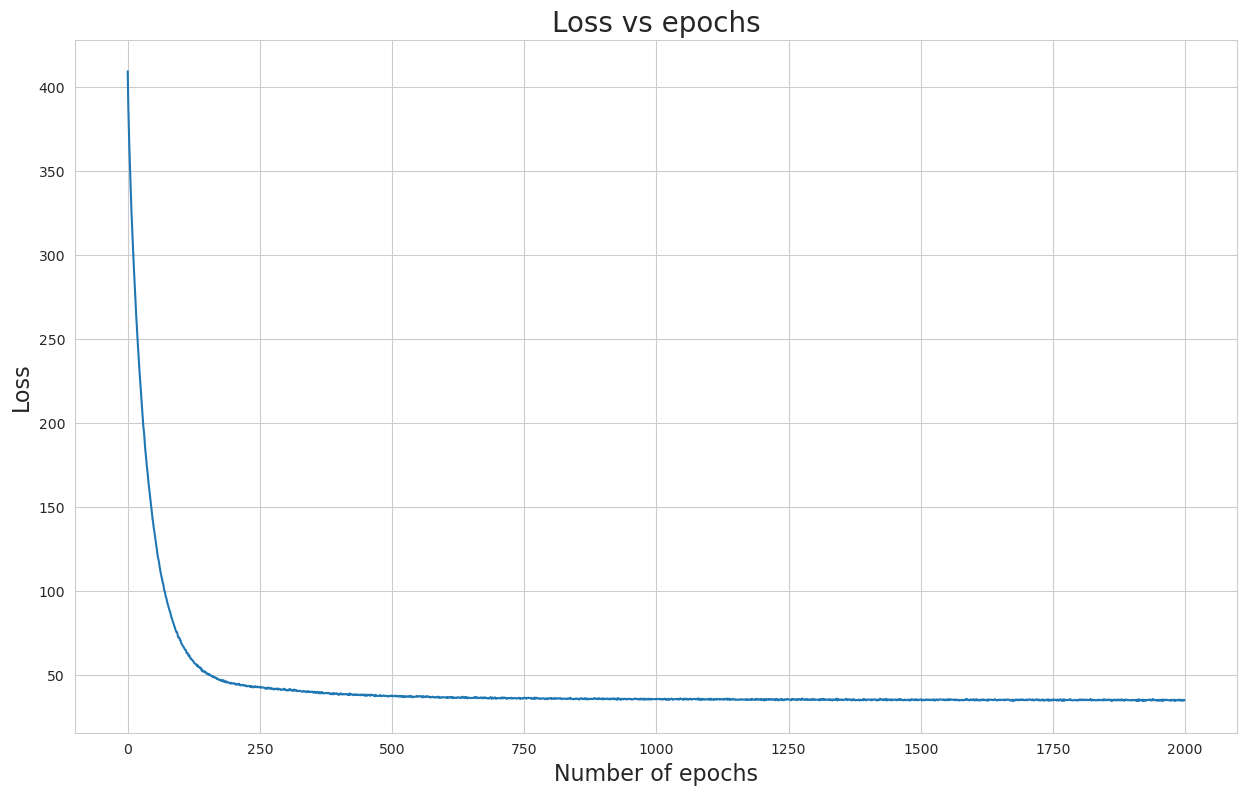

In [49]:
plt.figure(figsize=(15,9))
plt.plot(loss_per_epoch.keys(),loss_per_epoch.values())
plt.title("Loss vs epochs",fontsize=20)
plt.xlabel("Number of epochs",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.show()

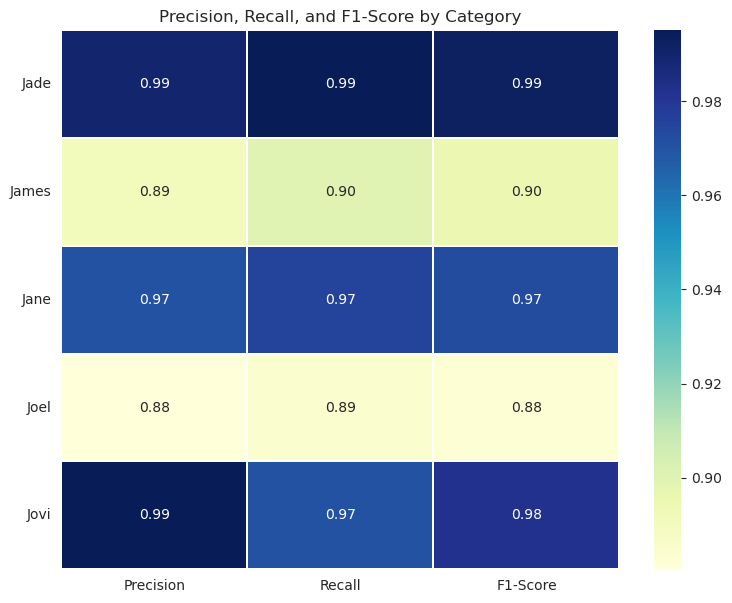

In [50]:
predicted_classes=np.argmax(network.forward_pass(test_images,is_training=False),axis=1)
true_classes = np.argmax(test_labels, axis=1)

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average=None, labels=list(mapping.values()))
recall = recall_score(true_classes, predicted_classes, average=None, labels=list(mapping.values()))
f1 = f1_score(true_classes, predicted_classes, average=None, labels=list(mapping.values()))
metrics_table = pd.DataFrame({'Precision': precision,'Recall': recall,'F1-Score': f1}, index=list(mapping.keys()))

plt.figure(figsize=(9, 7))
sns.heatmap(metrics_table, annot=True, fmt=".2f", cmap="YlGnBu",lw=0.01, cbar=True)
plt.title("Precision, Recall, and F1-Score by Category")
plt.yticks(rotation=0)
plt.show()

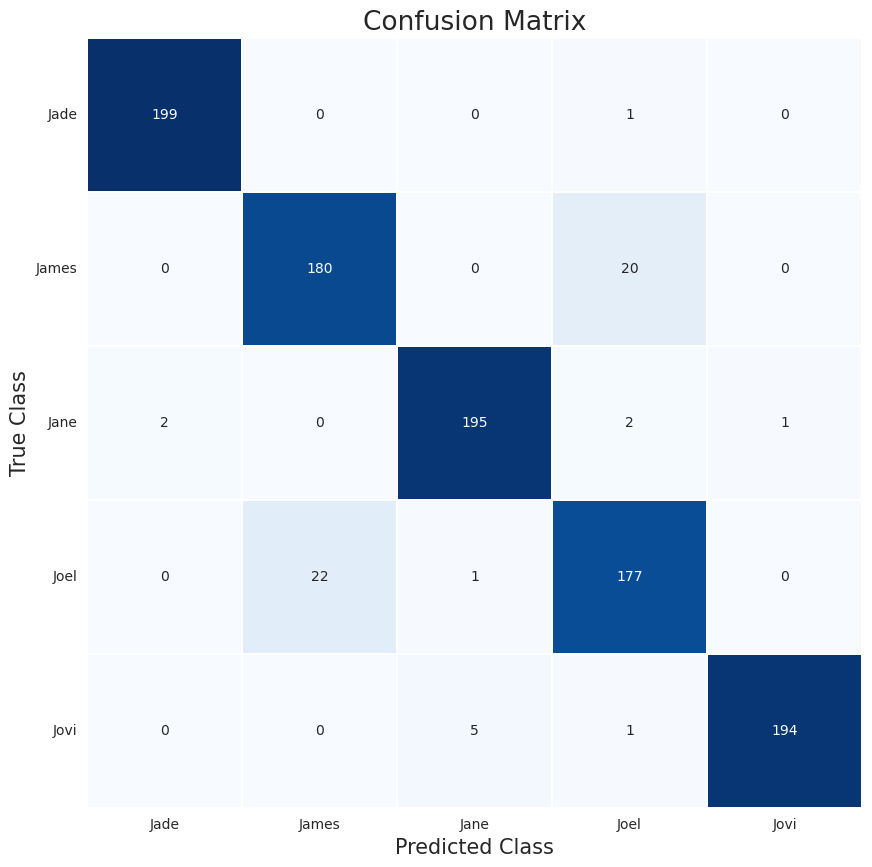

Accuracy: 94.5000%
Precision (Macro): 94.5351%
Recall (Macro): 94.5000%
F1-Score (Macro): 94.5136%


In [51]:
conf_matrix=pd.DataFrame(confusion_matrix(true_classes,predicted_classes,labels=list(mapping.values())),index=list(mapping.keys()),columns=list(mapping.keys()))
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix,lw=0.01,cmap='Blues',annot=True,cbar=False,fmt='d')
plt.title("Confusion Matrix",fontsize=19)
plt.yticks(rotation=0)
plt.xlabel("Predicted Class",fontsize=15)
plt.ylabel("True Class",fontsize=15)
plt.show()
print(f"Accuracy: {accuracy*100:.4f}%")
print(f"Precision (Macro): {precision*100:.4f}%")
print(f"Recall (Macro): {recall*100:.4f}%")
print(f"F1-Score (Macro): {f1*100:.4f}%")